In [124]:
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pyproj import Geod


In [125]:
sns.set_style("whitegrid")

### 1. Loading dataset

In [126]:
df = pd.read_csv("data/E-Scooter_Trips_-_2020.csv")
df.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Vendor,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location
0,3eb9a2a3-3266-4559-b1ec-e83a6f7972ab,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,"1,153","1,027",spin,68.0,68.0,ENGLEWOOD,ENGLEWOOD,41.780068,-87.642266,POINT (-87.64226608 41.78006847),41.780068,-87.642266,POINT (-87.64226608 41.78006847)
1,82dd7b8f-8de0-4f25-829b-b32bf47e8419,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,17,91,spin,22.0,21.0,LOGAN SQUARE,AVONDALE,41.922903,-87.704301,POINT (-87.70430082 41.92290349),41.939283,-87.710757,POINT (-87.71075685 41.93928256)
2,9120cbf3-f749-49b6-b894-0e6e065cd731,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,"2,883",724,spin,3.0,6.0,UPTOWN,LAKE VIEW,41.965435,-87.655145,POINT (-87.65514456 41.96543532),41.943514,-87.657498,POINT (-87.65749768 41.9435138)
3,cf2e4abc-2649-49be-924b-468a1aefc4c8,08/12/2020 05:00:00 AM,08/12/2020 05:00:00 AM,5,21,spin,31.0,31.0,LOWER WEST SIDE,LOWER WEST SIDE,41.848335,-87.675179,POINT (-87.67517932 41.84833501),41.848335,-87.675179,POINT (-87.67517932 41.84833501)
4,0448afb5-ab64-4090-b528-e3050e7eb0f2,08/12/2020 07:00:00 AM,08/12/2020 07:00:00 AM,"1,179",245,spin,6.0,6.0,LAKE VIEW,LAKE VIEW,41.943514,-87.657498,POINT (-87.65749768 41.9435138),41.943514,-87.657498,POINT (-87.65749768 41.9435138)


### 2. Data information

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630816 entries, 0 to 630815
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip ID                      630816 non-null  object 
 1   Start Time                   630816 non-null  object 
 2   End Time                     630816 non-null  object 
 3   Trip Distance                630816 non-null  object 
 4   Trip Duration                630816 non-null  object 
 5   Vendor                       630816 non-null  object 
 6   Start Community Area Number  629934 non-null  float64
 7   End Community Area Number    629598 non-null  float64
 8   Start Community Area Name    629934 non-null  object 
 9   End Community Area Name      629598 non-null  object 
 10  Start Centroid Latitude      629934 non-null  float64
 11  Start Centroid Longitude     629934 non-null  float64
 12  Start Centroid Location      629934 non-null  object 
 13 

### 3. Data preprocessing
We create following rules for the data:
1. Trip needs to last at least 1.5 minutes
2. Length of a trip needs to be at least 150 meters

#### Removing commas from data and converting data type to Int

In [128]:
df["Trip Duration"] = df["Trip Duration"].str.replace(",", "")
df["Trip Duration"] = df["Trip Duration"].astype("int")
df["Trip Distance"] = df["Trip Distance"].str.replace(",", "")
df["Trip Distance"] = df["Trip Distance"].astype("int")

In [129]:
original_shape = df.shape

#### Dropping rows where distance is less than 150 meters or time is less than 90 seconds

In [130]:
df = df.drop(df[(df['Trip Distance'] < 150) | (df['Trip Duration'] < 90)].index)
new_shape = df.shape

In [131]:
print(f"Number of rows dropped: {original_shape[0] - new_shape[0]}")

Number of rows dropped: 83596


### 4. Number of trips by date, day of week and hour

#### Converting start time to Datetime data type and creating new column: Start Date

In [132]:
df.head()['Start Time']
df['Start Date'] = pd.to_datetime(df['Start Time']).dt.date
df['Start Date'] = pd.to_datetime(df['Start Date'])

In [133]:
ntd = df.groupby("Start Date")["Start Date"].agg(["count"]).reset_index()
ntd.columns = ["Date", "Trips"]
ntd.head()

,Date,Trips
0,2020-08-12,2927
1,2020-08-13,3697
2,2020-08-14,4460
3,2020-08-15,5023
4,2020-08-16,5296


#### Average trips per day

In [134]:
atpd = round(ntd["Trips"].mean())
print(f"Average trips per day: {atpd} trips")

Average trips per day: 4449 trips


#### 4.1. Number of trips per date

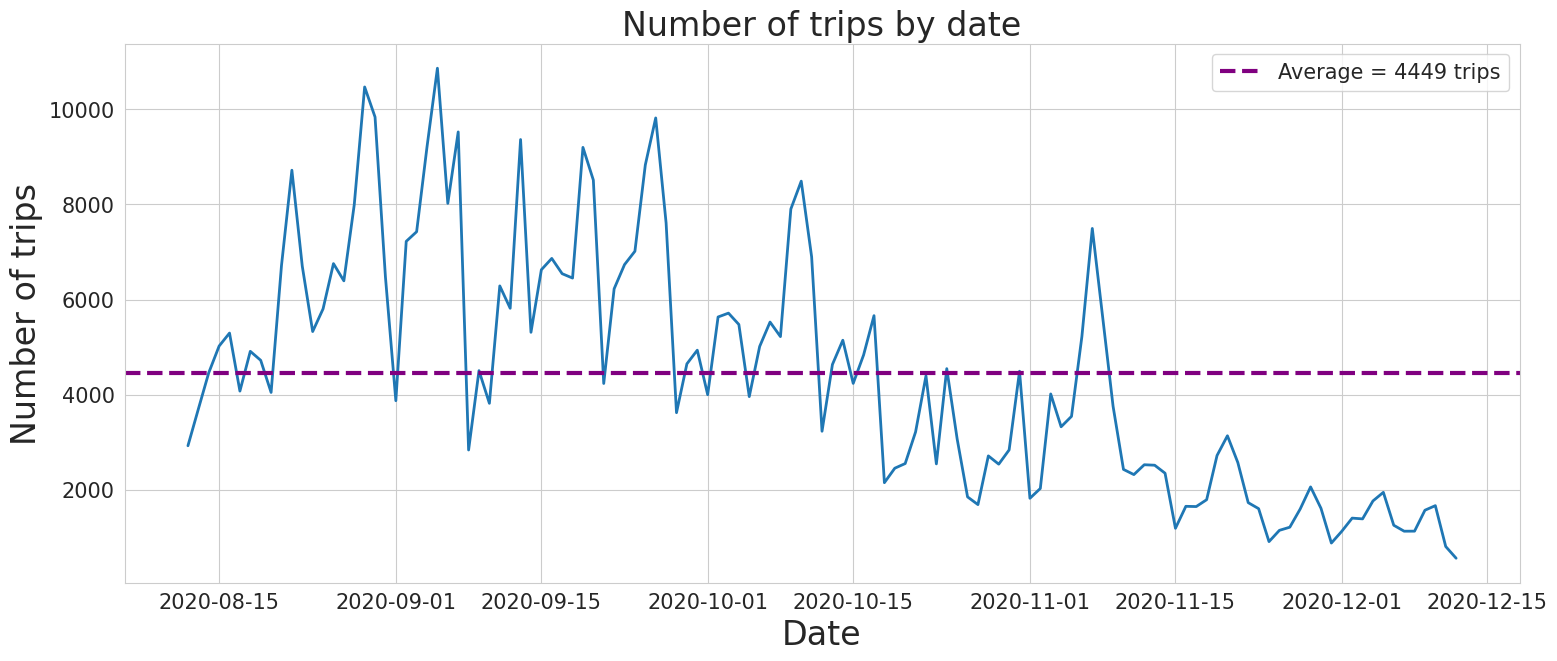

In [135]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trips", data=ntd, linewidth=2)
plot.axhline(atpd, linestyle="--", color="purple", label=f"Average = {atpd} trips", linewidth=3)
plt.title("Number of trips by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.2. Number of trips by day of week

#### Extracting day of week from Start Date column

In [136]:
df["Day of Week"] = df["Start Date"].dt.day_name()

In [137]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tdw = df.groupby("Day of Week")["Day of Week"].agg(["count"]).reindex(cats).reset_index()
tdw.columns = ["Day of Week", "Trips"]
tdw

,Day of Week,Trips
0,Monday,61128
1,Tuesday,60091
2,Wednesday,72843
3,Thursday,72408
4,Friday,88764
5,Saturday,105808
6,Sunday,86178


#### Average trips per day of week

In [138]:
atdw = round(tdw["Trips"].mean())
print(f"Average trips per day of week: {atdw}")

Average trips per day of week: 78174


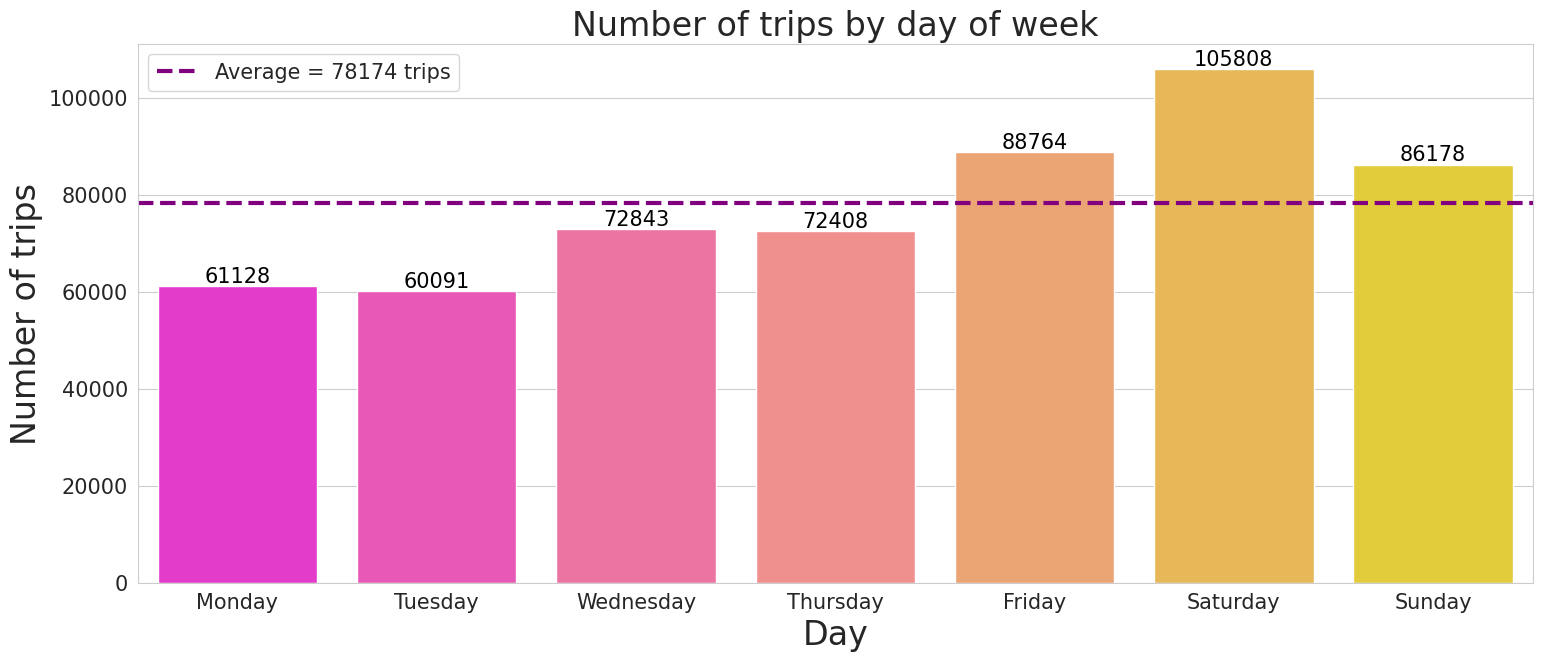

In [139]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Trips", data=tdw, palette="spring")
for p in plot.patches:
    plot.annotate('{:.0f}'.format(p.get_height()),
                  (p.get_x() + 0.4, p.get_height()),
                  ha='center', va='bottom', color='black', size=15)
plot.axhline(atdw, linestyle="--", color="purple", label=f"Average = {atdw} trips", linewidth=3)
plt.title("Number of trips by day of week", size=24)
plt.xlabel("Day", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.3. Distribution of trips over hours of the day

In [140]:
df["Hour"] = pd.to_datetime(df["Start Time"]).dt.hour

In [141]:
thd = df["Hour"].value_counts().to_frame().reset_index()
thd.columns = ["Hour", "Trips"]
thd

,Hour,Trips
0,17,58587
1,18,58403
2,16,52854
3,19,49838
4,15,47824
5,14,41795
6,20,39606
7,13,37959
8,12,34670
9,21,30926


#### Average trips per hour

In [142]:
athd = round(thd["Trips"].mean())
print(f"Average trips per hour: {athd}")

Average trips per hour: 22801


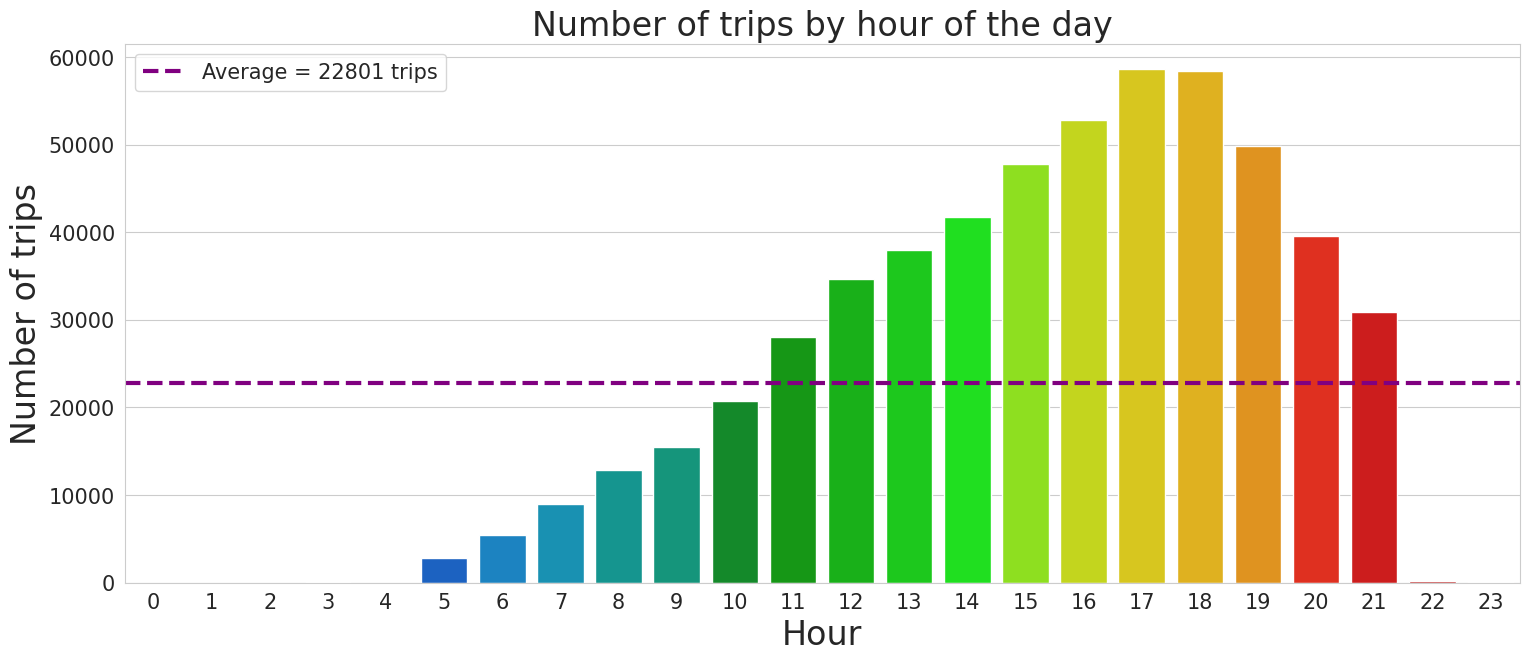

In [143]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Trips", data=thd, palette="nipy_spectral")
plot.axhline(athd, linestyle="--", color="purple", label=f"Average = {athd} trips", linewidth=3)
plt.title("Number of trips by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.4. Number of trips by start area

In [144]:
ntbsa = df["Start Community Area Name"].value_counts().to_frame().reset_index()
ntbsa.columns = ["Start Community Area Name", "Trips"]
ntbsa

,Start Community Area Name,Trips
0,LAKE VIEW,88850
1,LINCOLN PARK,70440
2,WEST TOWN,53413
3,NEAR WEST SIDE,28375
4,LOGAN SQUARE,25808
...,...,...
72,LOOP,147
73,FOREST GLEN,143
74,BURNSIDE,123
75,EDISON PARK,19


#### 4.5. Number of trips by destination area

In [145]:
ntbea = df["End Community Area Name"].value_counts().to_frame().reset_index()
ntbea.columns = ["End Community Area Name", "Trips"]
ntbea

,End Community Area Name,Trips
0,LAKE VIEW,88095
1,LINCOLN PARK,68609
2,WEST TOWN,53375
3,NEAR WEST SIDE,28101
4,LOGAN SQUARE,26236
...,...,...
72,LOOP,254
73,FOREST GLEN,188
74,BURNSIDE,173
75,EDISON PARK,31


### 5. Average trip speed (km/h)

#### Creating new column: Average Speed

In [146]:
df["Average Speed"] = (df["Trip Distance"] / 1000) / (df["Trip Duration"] / 3600)

#### Average speed of trip

In [147]:
avs = round(df['Average Speed'].mean(), 2)
print(f"Average speed of trip: {avs} km/h")

Average speed of trip: 14.25 km/h


#### 5.1 Average speed by date

In [148]:
atsbd = df.groupby(["Start Date"]).agg({"Average Speed": "mean"}).reset_index()
atsbd.columns = ["Date", "Average Speed"]
atsbd.head()

,Date,Average Speed
0,2020-08-12,10.624705
1,2020-08-13,11.291829
2,2020-08-14,12.718869
3,2020-08-15,11.821137
4,2020-08-16,11.337374


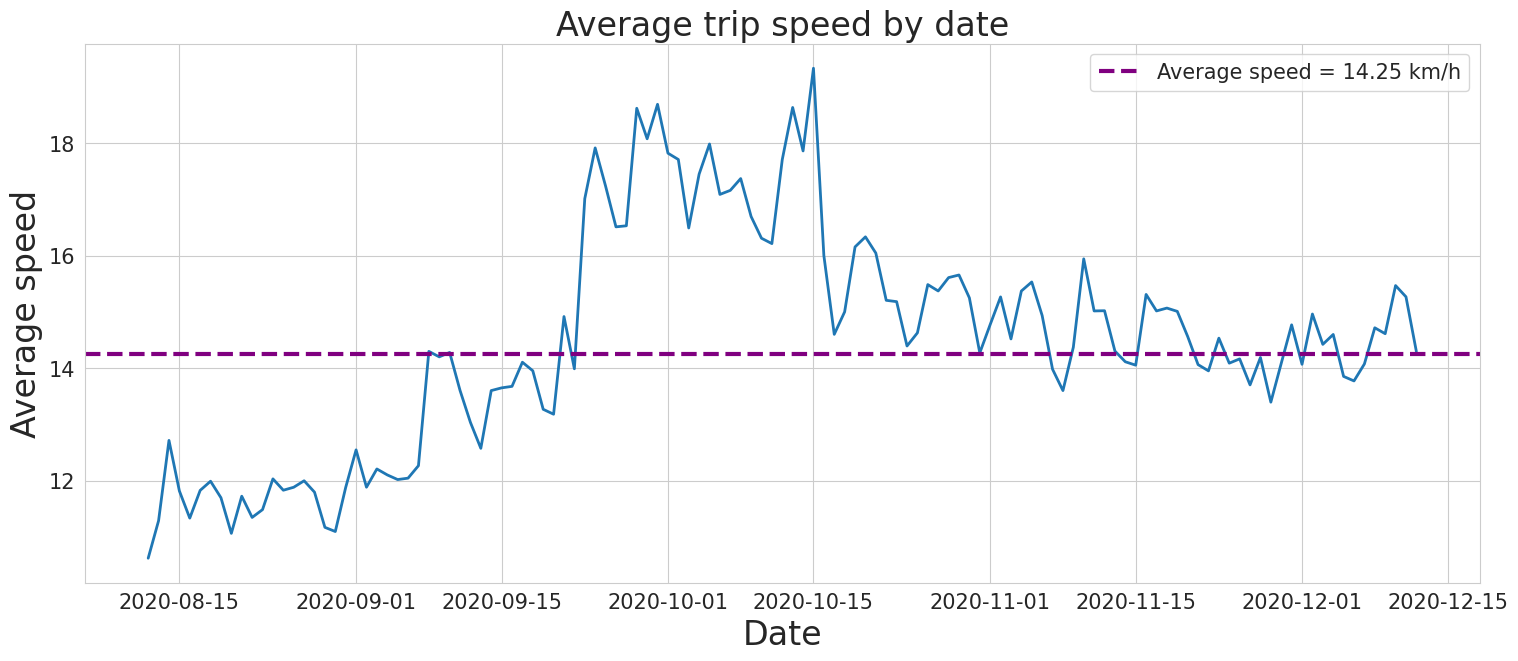

In [149]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Average Speed", data=atsbd, linewidth=2)
plot.axhline(avs, linestyle="--", color="purple", label=f"Average speed = {avs} km/h", linewidth=3)
plt.title("Average trip speed by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average speed", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 5.2 Average speed by day of week

In [150]:
aspd = df.groupby(["Day of Week"]).agg({"Average Speed": "mean"})
aspd.columns = ["Average Speed"]
aspd = aspd.reset_index()
aspd

,Day of Week,Average Speed
0,Friday,14.430455
1,Monday,14.207338
2,Saturday,13.684364
3,Sunday,13.550160
4,Thursday,14.826528
5,Tuesday,14.735468
6,Wednesday,14.708565


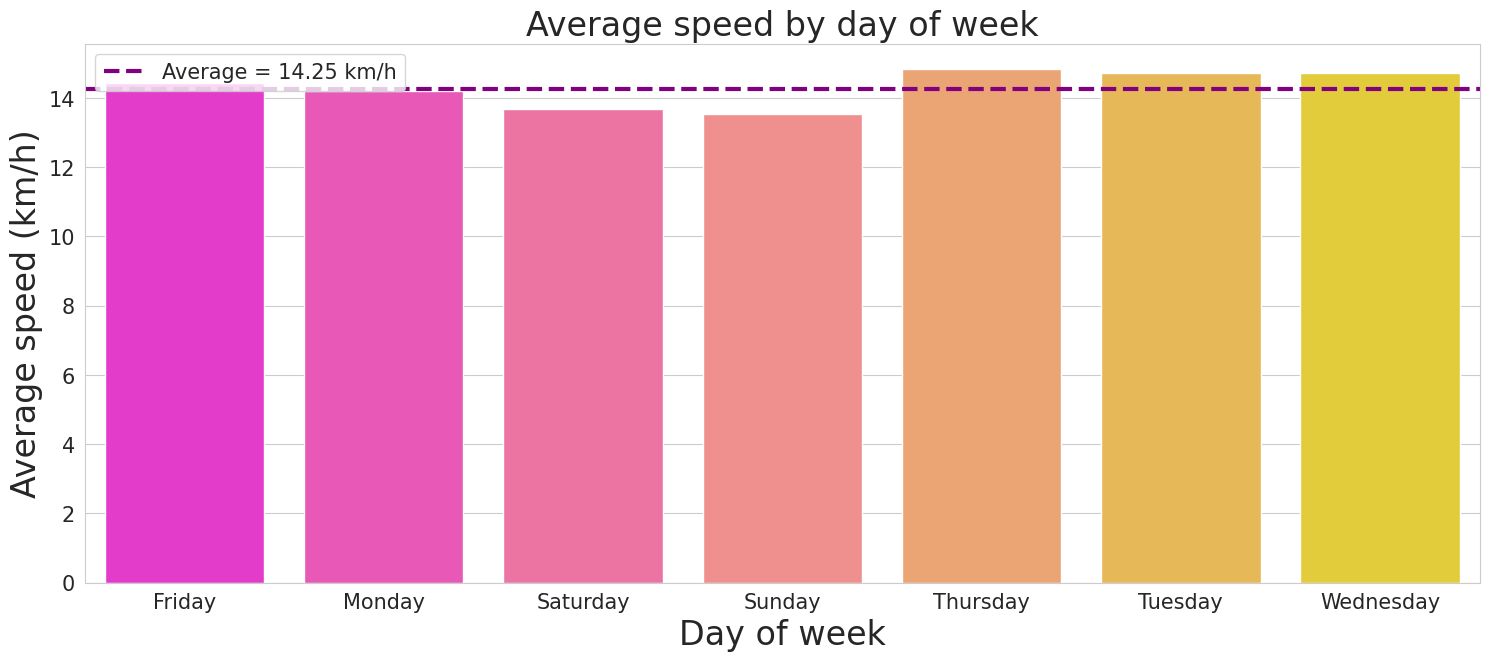

In [151]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Average Speed", data=aspd, palette="spring")
plot.axhline(avs, linestyle="--", color="purple", label=f"Average = {avs} km/h", linewidth=3)
plt.title("Average speed by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average speed (km/h)", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 5.3 Average speed by start hour

In [152]:
asph = df.groupby(["Hour"]).agg({"Average Speed": "mean"})
asph.columns = ["Average Speed"]
asph = asph.reset_index()
asph

,Hour,Average Speed
0,0,11.500043
1,1,12.800828
2,2,15.480470
3,3,20.016426
4,4,19.404634
5,5,16.847234
6,6,17.849784
7,7,17.319672
8,8,16.629050
9,9,15.736661


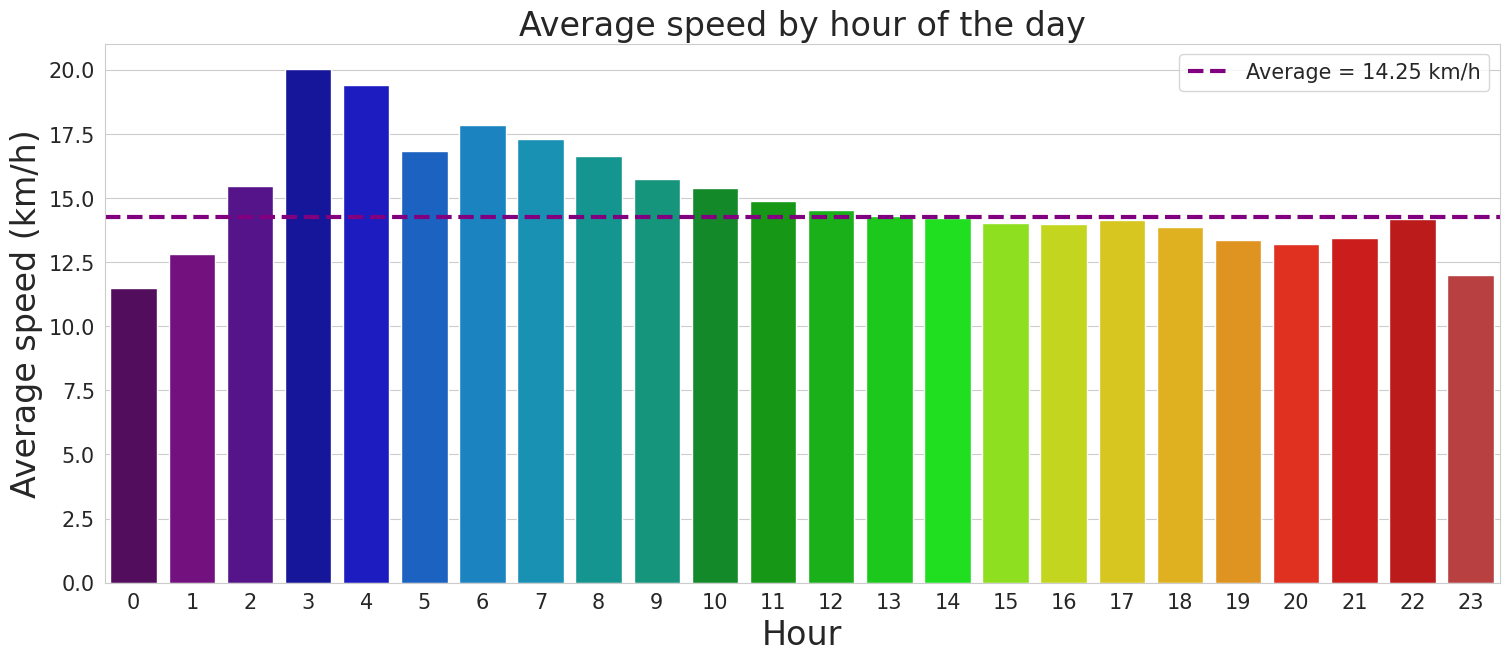

In [153]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Speed", data=asph, palette="nipy_spectral")
plot.axhline(avs, linestyle="--", color="purple", label=f"Average = {avs} km/h", linewidth=3)
plt.title("Average speed by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average speed (km/h)", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 6. Average trip distance

In [154]:
avd = round(df["Trip Distance"].mean(), 2)
print(f"Average distance per trip: {avd}m")

Average distance per trip: 3347.42m


#### 6.1. Average trip distance by date

In [155]:
atdbd = df.groupby(["Start Date"]).agg({"Trip Distance": "mean"}).reset_index()
atdbd.columns = ["Date", "Trip Distance"]
atdbd.head()

,Date,Trip Distance
0,2020-08-12,4324.697643
1,2020-08-13,4095.524209
2,2020-08-14,4255.495067
3,2020-08-15,4085.698188
4,2020-08-16,4358.191465


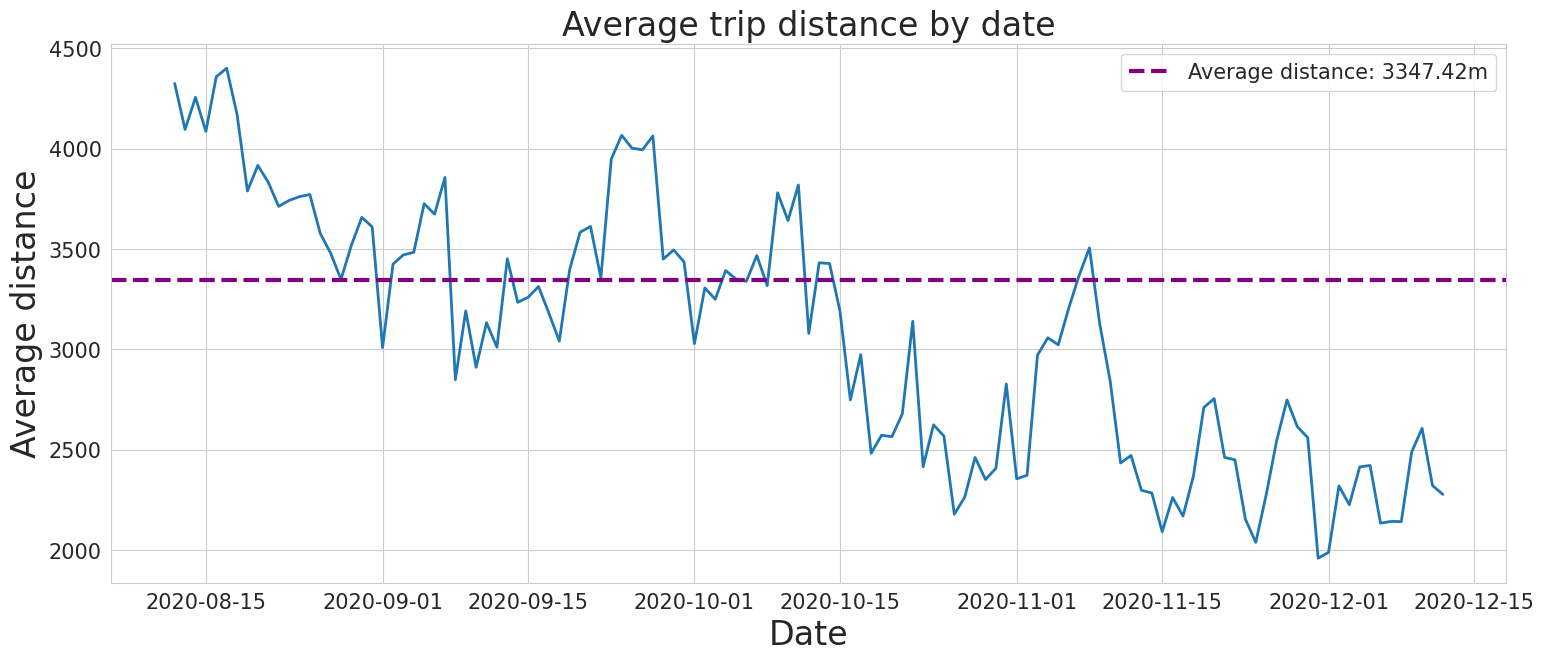

In [156]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trip Distance", data=atdbd, linewidth=2)
plot.axhline(avd, linestyle="--", color="purple", label=f"Average distance: {avd}m", linewidth=3)
plt.title("Average trip distance by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.2. Average trip distance by day of week

In [157]:
adbd = df.groupby(["Day of Week"]).agg({"Trip Distance": "mean"})
adbd.columns = ["Average Trip Distance"]
adbd = adbd.reset_index()
adbd

,Day of Week,Average Trip Distance
0,Friday,3320.206198
1,Monday,3345.799028
2,Saturday,3378.677123
3,Sunday,3516.527617
4,Thursday,3274.180049
5,Tuesday,3208.915145
6,Wednesday,3323.545859


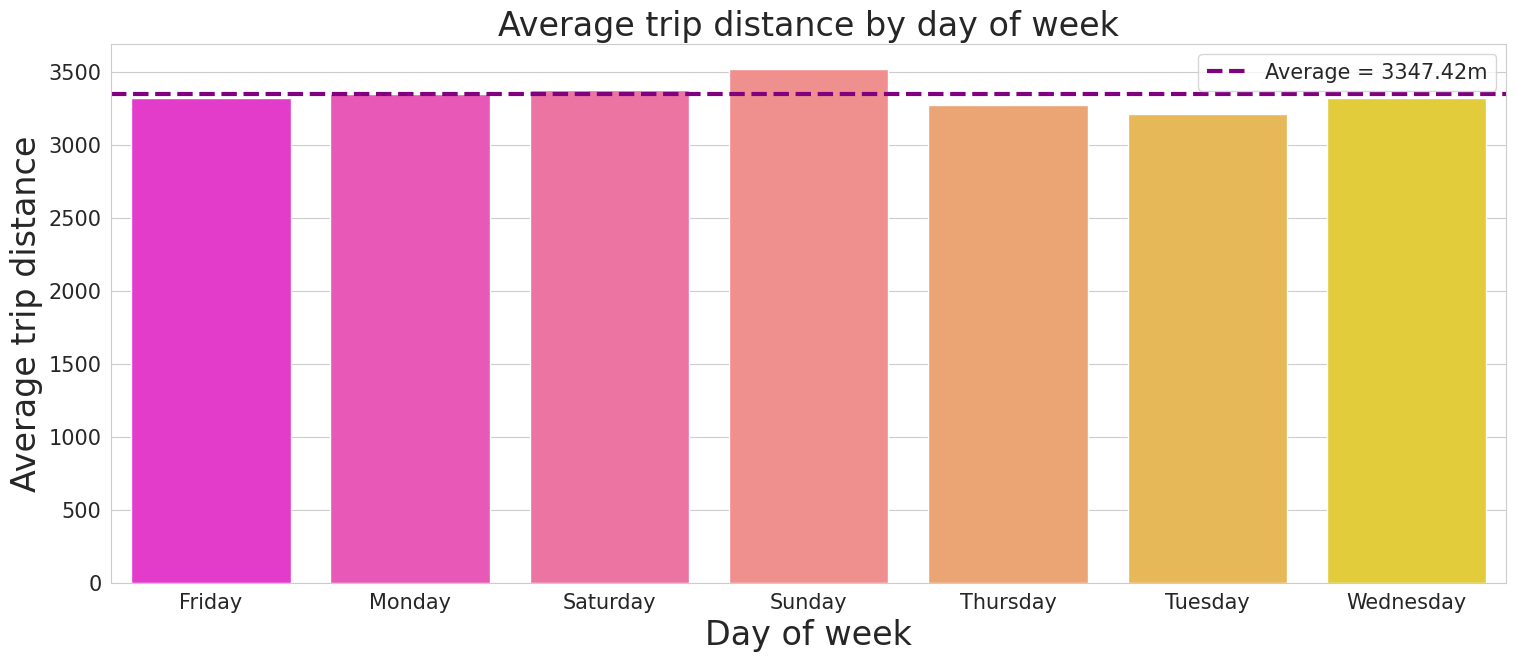

In [158]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Average Trip Distance", data=adbd, palette="spring")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd}m", linewidth=3)
plt.title("Average trip distance by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average trip distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.3. Average trip distance by hour of the day

In [159]:
adbh = df.groupby(["Hour"]).agg({"Trip Distance": "mean"})
adbh.columns = ["Average Trip Distance"]
adbh = adbh.reset_index()
adbh

,Hour,Average Trip Distance
0,0,2441.333333
1,1,2641.272727
2,2,6141.857143
3,3,9100.921053
4,4,5508.857143
5,5,3131.513284
6,6,2881.840211
7,7,2712.753239
8,8,2750.184161
9,9,2842.364840


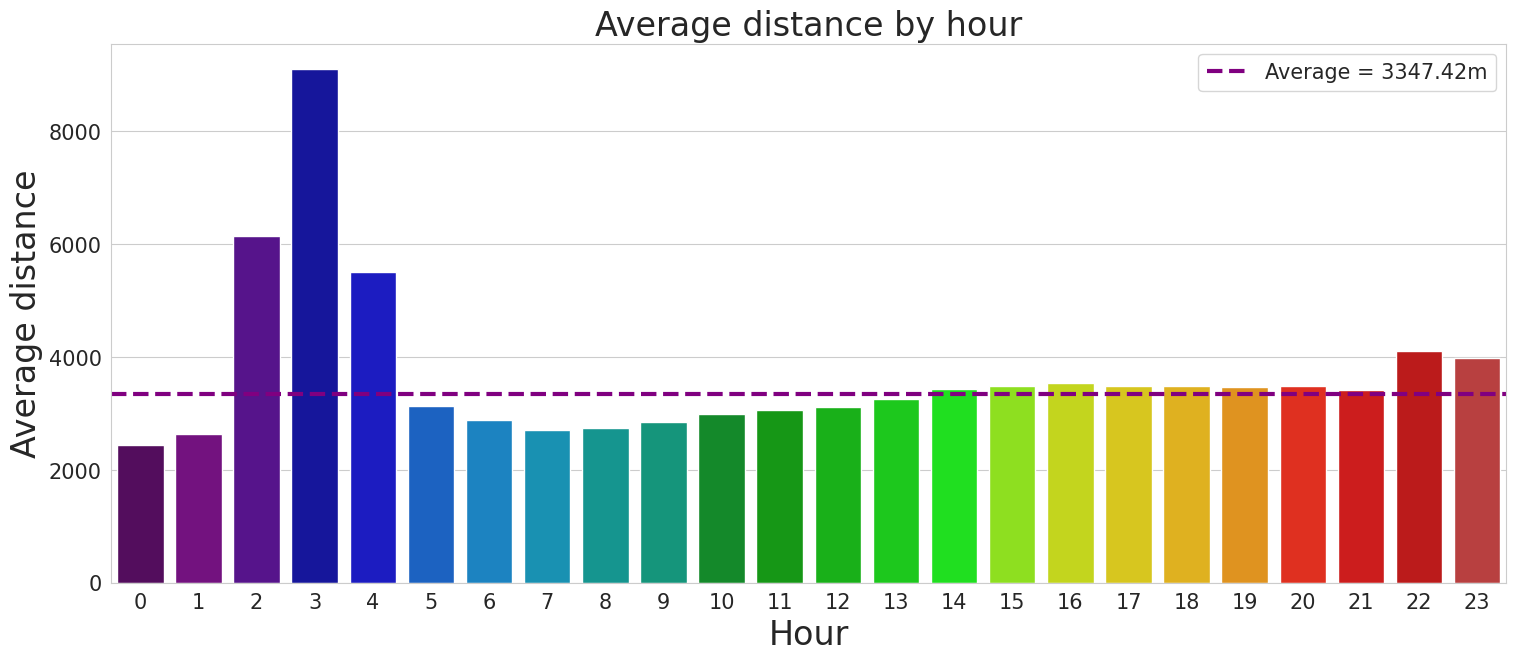

In [160]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Trip Distance", data=adbh, palette="nipy_spectral")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd}m", linewidth=3)
plt.title("Average distance by hour", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7. Trips statistics for first and last 15 days

#### First 15 days

In [161]:
ftd = df[(df["Start Date"] >= "2020-08-12") & (df["Start Date"] <= "2020-08-26")]
ftd["Time Period"] = "First 15 Days"

#### Last 15 days

In [162]:
ltd = df[(df["Start Date"] >= "2020-11-12") & (df["Start Date"] <= "2020-11-26")]
ltd["Time Period"] = "Last 15 Days"

In [163]:
fltd = pd.concat([ftd, ltd])

#### 7.1. Statistics by time period

In [164]:
fl_15 = fltd.groupby("Time Period").agg({"Time Period": "count",
                                         "Trip Distance": "mean",
                                         "Trip Duration": "mean",
                                         "Average Speed": "mean"})
fl_15.columns = ["Trips", "Trips Distance", "Trips Duration", "Average Speed"]
fl_15 = fl_15.reset_index()
fl_15

,Time Period,Trips,Trips Distance,Trips Duration,Average Speed
0,First 15 Days,79187,3938.061083,1448.776201,11.668653
1,Last 15 Days,28729,2404.381566,742.904591,14.517974


#### 7.2. Statistics by day of week and time period

In [165]:
fltdg = fltd.groupby(["Day of Week", "Time Period"]).agg({"Time Period": "count",
                                                          "Trip Distance": "mean",
                                                          "Trip Duration": "mean",
                                                          "Average Speed": "mean"})
fltdg.columns = ["Trips", "Trips Distance", "Trips Duration", "Average Speed"]
fltdg = fltdg.reset_index()
fltdg

,Day of Week,Time Period,Trips,Trips Distance,Trips Duration,Average Speed
0,Friday,First 15 Days,11176,4001.340104,1451.206514,12.123040
1,Friday,Last 15 Days,5655,2551.222635,808.118833,14.450714
2,Monday,First 15 Days,9404,4038.129519,1430.084751,11.946377
3,Monday,Last 15 Days,3259,2209.149432,636.962258,14.931069
4,Saturday,First 15 Days,13742,3848.919735,1411.233590,11.522123
5,Saturday,Last 15 Days,4924,2377.294070,756.240861,14.090013
6,Sunday,First 15 Days,11997,4013.857964,1492.836376,11.421907
7,Sunday,Last 15 Days,2923,2303.794389,761.873418,13.996133
8,Thursday,First 15 Days,7745,4001.970562,1563.824403,11.174175
9,Thursday,Last 15 Days,6465,2585.311214,783.619180,14.771302


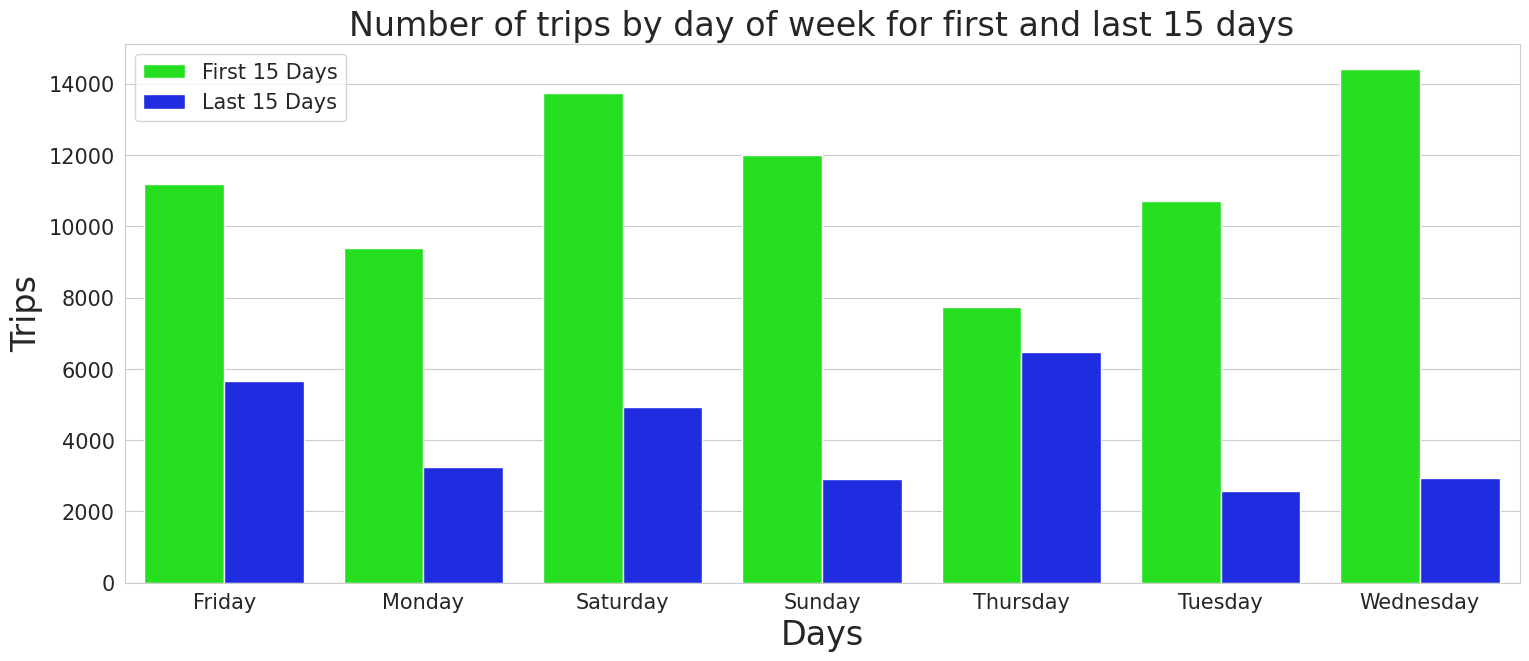

In [166]:
plt.figure(figsize=(18, 7))
sns.barplot(x="Day of Week", y="Trips", hue="Time Period", data=fltdg, palette="hsv")
plt.title("Number of trips by day of week for first and last 15 days", size=24)
plt.xlabel("Days", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 7.3. Statistics by hour and time period

In [167]:
fltdh = fltd.groupby(["Hour", "Time Period"])["Time Period"].agg(["count"]).reset_index()
fltdh.columns = ["Hour", "Time Period", "Trips"]
fltdh

,Hour,Time Period,Trips
0,0,First 15 Days,2
1,1,First 15 Days,1
2,2,First 15 Days,5
3,3,First 15 Days,3
4,3,Last 15 Days,3
5,4,First 15 Days,3
6,5,First 15 Days,307
7,5,Last 15 Days,255
8,6,First 15 Days,534
9,6,Last 15 Days,422


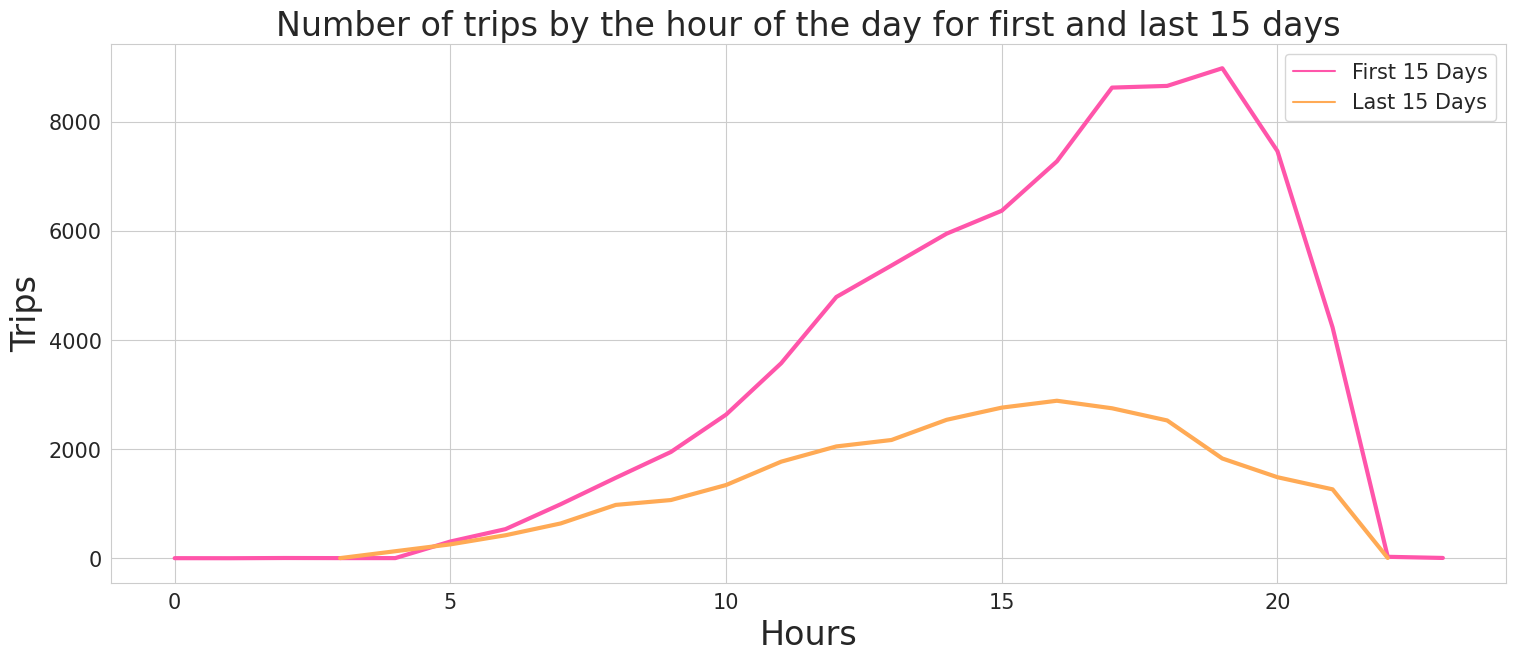

In [168]:
plt.figure(figsize=(18, 7))
sns.lineplot(x="Hour", y="Trips", hue="Time Period", data=fltdh, palette="spring", linewidth=3)
plt.title("Number of trips by the hour of the day for first and last 15 days", size=24)
plt.xlabel("Hours", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 8. Starts analysis


#### 8.1. Starts count on map

In [169]:
df_location_start = df[['Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
df_location_start, counts_start = np.unique(df_location_start, return_counts=True, axis=0)
df_location_start = np.append(df_location_start, counts_start.reshape((df_location_start.shape[0], -1)), axis=1)

In [170]:
def draw_starts_number_map(data):
    location_start_map = folium.Map(location=[41.895140898, -87.624255632], zoom_start=13)
    for row in data:
        lat = row[0]
        long = row[1]
        count = row[2]
        radius = count / 3500
        color = "#FF4500"
        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Starts numer : {}<br>"""
        popup_text = popup_text.format(lat, long, count)
        folium.CircleMarker(location=(lat, long), fill=True, radius=radius, popup=popup_text, color=color).add_to(
            location_start_map)
    return location_start_map


draw_starts_number_map(df_location_start)

#### 8.1. Put back location

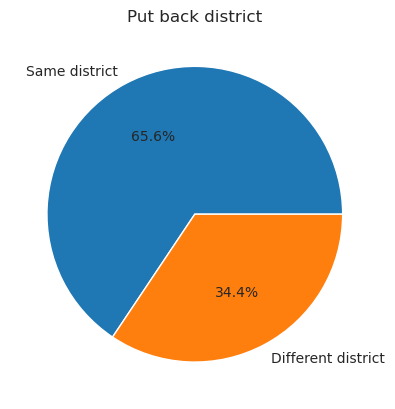

In [171]:
areas = df[["Start Community Area Name", 'End Community Area Name']].value_counts().to_frame().reset_index()
areas.columns = ["Start Community Area Name", 'End Community Area Name', "count"]
same_district = areas[(areas["Start Community Area Name"] == areas['End Community Area Name'])].reset_index()
different_district = areas[(areas["Start Community Area Name"] != areas['End Community Area Name'])].reset_index()

fig, ax = plt.subplots()
ax.pie([same_district["count"].sum(), different_district["count"].sum()],
       labels=["Same district", "Different district"], autopct='%1.1f%%')
plt.title("Put back district")
plt.show()

### 9. Traffic flow analysis


In [172]:
areas = df[["Start Community Area Number", 'End Community Area Number']].dropna()
area_count = np.unique(areas).shape[0]
different_district = areas[
    (areas["Start Community Area Number"] != areas['End Community Area Number'])]  #.reset_index()
transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(different_district.iloc):
    t0 = np.int(trip[0])
    t1 = np.int(trip[1])
    if t0 > t1:
        transfer_arr[t0 - 1, t1 - 1] += 1
    else:
        transfer_arr[t0 - 1, t1 - 1] -= 1

In [173]:
transfer_arr_norm = transfer_arr / np.linalg.norm(transfer_arr)
print(transfer_arr_norm.shape)

(77, 77)


In [174]:
area_geo_position = df[['Start Community Area Number', 'Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
area_geo_position = np.unique(area_geo_position, axis=0)

In [175]:
list_colors = [
    "#00FF00",
    "#12FF00",
    "#24FF00",
    "#35FF00",
    "#47FF00",
    "#58FF00",
    "#6AFF00",
    "#7CFF00",
    "#8DFF00",
    "#9FFF00",
    "#B0FF00",
    "#C2FF00",
    "#D4FF00",
    "#E5FF00",
    "#F7FF00",
    "#FFF600",
    "#FFE400",
    "#FFD300",
    "#FFC100",
    "#FFAF00",
    "#FF9E00",
    "#FF8C00",
    "#FF7B00",
    "#FF6900",
    "#FF5700",
    "#FF4600",
    "#FF3400",
    "#FF2300",
    "#FF1100",
    "#FF0000",
]
color_dict = {i: list_colors[i] for i in range(len(list_colors))}

In [176]:
def draw_flow_map(treshold=1):
    max_count = np.max(transfer_arr)
    print(max_count)
    location_start_map = folium.Map(location=[41.895140898, -87.624255632], zoom_start=12)
    for y in range(transfer_arr.shape[0]):
        for x in range(transfer_arr.shape[1]):
            if x > y and np.abs(transfer_arr[x, y]) > max_count * treshold:
                start_lat = area_geo_position[x, 1]
                start_long = area_geo_position[x, 2]
                end_lat = area_geo_position[y, 1]
                end_long = area_geo_position[y, 2]

                coordinates = [
                    [start_lat, start_long],
                    [end_lat, end_long]
                ]

                color = np.floor(np.log(np.abs(transfer_arr[x, y])) * (30 / np.ceil(np.log(max_count))))
                line = folium.PolyLine(locations=coordinates, weight=color / 2, color=color_dict[color])
                location_start_map.add_child(line)

                geodesic = Geod(ellps='WGS84')
                if transfer_arr[x, y] > 0:
                    rotation = geodesic.inv(start_long, start_lat, end_long, end_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(location=(
                    (end_lat - start_lat) * 0.95 + start_lat, (end_long - start_long) * 0.95 + start_long),
                                                             color=color_dict[color], number_of_sides=3,
                                                             radius=color * 0.75, rotation=rotation)
                else:
                    rotation = geodesic.inv(end_long, end_lat, start_long, start_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(
                        location=((start_lat - end_lat) * 0.95 + end_lat, (start_long - end_long) * 0.95 + end_long),
                        color=color_dict[color], number_of_sides=3, radius=color * 0.75, rotation=rotation)
                location_start_map.add_child(arrow_head)
    return location_start_map

In [177]:
draw_flow_map(0.01)

12921


#### 9.1. Traffic flow - morning

In [178]:
def parseDateTime(dateTime: str, fromTime: int, toTime: int):
    result = []
    for dT in dateTime:
        tmp = dT.split()[1:3]
        hour = int(tmp[0].split(':')[0])
        if tmp[1] == 'PM':
            hour += 12
        if fromTime <= hour <= toTime:
            result.append(True)
        else:
            result.append(False)
    return np.array(result)

In [179]:
areas = df[["Start Time", "Start Community Area Number", "End Community Area Number"]].dropna()
district_filter = np.array(areas["Start Community Area Number"] != areas['End Community Area Number'])
hour_filter = parseDateTime(areas['Start Time'], 6, 10)
sum_filter = []
for i in range(len(district_filter)):
    if district_filter[i] == True and hour_filter[i] == True:
        sum_filter.append(True)
    else:
        sum_filter.append(False)
hour_district = np.array(areas[sum_filter])
transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(hour_district):
    t0 = np.int(trip[1])
    t1 = np.int(trip[2])
    if t0 > t1:
        transfer_arr[t0 - 1, t1 - 1] += 1
    else:
        transfer_arr[t0 - 1, t1 - 1] -= 1

In [180]:
draw_flow_map(0.01)

1307


#### 9.2. Traffic flow - afternoon


In [181]:
draw_flow_map(0.01)

1307
